In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 4.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from catboost import Pool, CatBoostRegressor

warnings.filterwarnings("ignore")

In [ ]:
STORE_ID = 'STORE_1'

In [ ]:
sales = pd.read_csv('data/shop_sales.csv')
calendar = pd.read_csv('data/shop_sales_dates.csv')

In [ ]:
def make_df(sales, calendar, store_id):
    store_sales = sales[sales['store_id']==store_id]
    df = store_sales.merge(calendar, how='left', on='date_id')
    df = df.drop(['store_id', 'date_id', 'wm_yr_wk', 'weekday', 'event_name_2',
                'event_type_2', 'CASHBACK_STORE_2', 'CASHBACK_STORE_3'],
                axis=1)
    df['event_name_1'] = df['event_name_1'].fillna('not_event')
    df['event_type_1'] = df['event_type_1'].fillna('not_event')
    df['date'] = pd.to_datetime(df['date'])
    return df

In [ ]:
df = make_df(sales, calendar, STORE_ID)

In [ ]:
df.head()

,item_id,cnt,date,wday,month,year,event_name_1,event_type_1,CASHBACK_STORE_1
0,STORE_1_064,0,2011-01-29,1,1,2011,not_event,not_event,0
1,STORE_1_064,1,2011-01-30,2,1,2011,not_event,not_event,0
2,STORE_1_064,0,2011-01-31,3,1,2011,not_event,not_event,0
3,STORE_1_064,0,2011-02-01,4,2,2011,not_event,not_event,0
4,STORE_1_064,0,2011-02-02,5,2,2011,not_event,not_event,1


In [ ]:
start_date = '2015-11-21'
end_date = '2016-01-21'
len(pd.date_range(start_date, end_date))

62

In [ ]:
def features_regression(df, target_col):

    feature_lags = [63, 64, 65, 66, 67, 68, 69]
    for lag in feature_lags:
        df.loc[:, f'{target_col}_lag_{lag}'] = df[target_col].shift(periods=lag, fill_value=0).values

    return df

In [ ]:
df = features_regression(df, 'cnt')
df.head()

,item_id,cnt,date,wday,month,year,event_name_1,event_type_1,CASHBACK_STORE_1,cnt_lag_63,cnt_lag_64,cnt_lag_65,cnt_lag_66,cnt_lag_67,cnt_lag_68,cnt_lag_69
0,STORE_1_064,0,2011-01-29,1,1,2011,not_event,not_event,0,0,0,0,0,0,0,0
1,STORE_1_064,1,2011-01-30,2,1,2011,not_event,not_event,0,0,0,0,0,0,0,0
2,STORE_1_064,0,2011-01-31,3,1,2011,not_event,not_event,0,0,0,0,0,0,0,0
3,STORE_1_064,0,2011-02-01,4,2,2011,not_event,not_event,0,0,0,0,0,0,0,0
4,STORE_1_064,0,2011-02-02,5,2,2011,not_event,not_event,1,0,0,0,0,0,0,0


In [ ]:
start_date = '2015-11-21'
end_date = '2016-01-21'

def split_train_test(df, start_date, end_date):
    valid_split = len(pd.date_range(start_date, end_date))

    val_df = df.groupby('item_id').tail(valid_split)
    train_df = df.drop(val_df.index)


    return train_df, val_df

In [ ]:
train_df, val_df = split_train_test(df, start_date, end_date)

In [ ]:
train_df

,item_id,cnt,date,wday,month,year,event_name_1,event_type_1,CASHBACK_STORE_1,cnt_lag_63,cnt_lag_64,cnt_lag_65,cnt_lag_66,cnt_lag_67,cnt_lag_68,cnt_lag_69
0,STORE_1_064,0,2011-01-29,1,1,2011,not_event,not_event,0,0,0,0,0,0,0,0
1,STORE_1_064,1,2011-01-30,2,1,2011,not_event,not_event,0,0,0,0,0,0,0,0
2,STORE_1_064,0,2011-01-31,3,1,2011,not_event,not_event,0,0,0,0,0,0,0,0
3,STORE_1_064,0,2011-02-01,4,2,2011,not_event,not_event,0,0,0,0,0,0,0,0
4,STORE_1_064,0,2011-02-02,5,2,2011,not_event,not_event,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27218,STORE_1_727,2,2015-11-16,3,11,2015,not_event,not_event,0,0,0,0,0,0,0,0
27219,STORE_1_727,4,2015-11-17,4,11,2015,not_event,not_event,0,0,0,0,0,0,0,0
27220,STORE_1_727,1,2015-11-18,5,11,2015,not_event,not_event,0,0,0,0,0,0,0,0
27221,STORE_1_727,0,2015-11-19,6,11,2015,not_event,not_event,0,0,0,0,0,0,0,0


In [ ]:
feature_names = train_df.columns.drop(['item_id', 'cnt']).tolist()
cat_features = ['event_name_1', 'event_type_1']

In [ ]:
models = {}
tr_preds = []
v_preds = []

for item in train_df['item_id'].unique():
    train_data = train_df[train_df['item_id']==item]
    val_data = val_df[val_df['item_id']==item]

    train_pool = Pool(
        train_data[feature_names],
        train_data['cnt'],
        cat_features = cat_features,
        feature_names=feature_names
    )
    val_pool = Pool(
        val_data[feature_names],
        val_data['cnt'],
        cat_features = cat_features,
        feature_names=feature_names
    )

    cb_model = CatBoostRegressor(
                n_estimators=700,
                random_state=52,
                early_stopping_rounds=75,
                verbose=0,
                eval_metric='MAPE'
    )

    cb_model.fit(train_pool, eval_set=val_pool)
    models[item] = cb_model

    forecast = cb_model.predict(train_pool)
    train_data['cnt_pred'] = forecast
    tr_preds.append(train_data[['item_id', 'date', 'cnt', 'cnt_pred']])

    forecast = cb_model.predict(val_pool)
    val_data['cnt_pred'] = forecast
    v_preds.append(val_data[['item_id', 'date', 'cnt', 'cnt_pred']])

train_preds = pd.concat(tr_preds)
val_preds = pd.concat(v_preds)

print(mean_absolute_error(train_preds['cnt'], train_preds['cnt_pred']))
print(mean_absolute_percentage_error(train_preds['cnt'], train_preds['cnt_pred']))
print('-' * 10)
print(mean_absolute_error(val_preds['cnt'], val_preds['cnt_pred']))
print(mean_absolute_percentage_error(val_preds['cnt'], val_preds['cnt_pred']))
print('-' * 10)
print(mean_absolute_error(val_preds['cnt'][:7], val_preds['cnt_pred'][:7]))
print(mean_absolute_percentage_error(val_preds['cnt'][:7], val_preds['cnt_pred'][:7]))
print('-' * 10)
print(mean_absolute_error(val_preds['cnt'][:30], val_preds['cnt_pred'][:30]))
print(mean_absolute_percentage_error(val_preds['cnt'][:30], val_preds['cnt_pred'][:30]))

4.212720028583337
3101579364506423.0
----------
5.557791291025047
7327531000649357.0
----------
0.27923238993330846
324554777161170.7
----------
0.40091401000574145
515159319049029.75


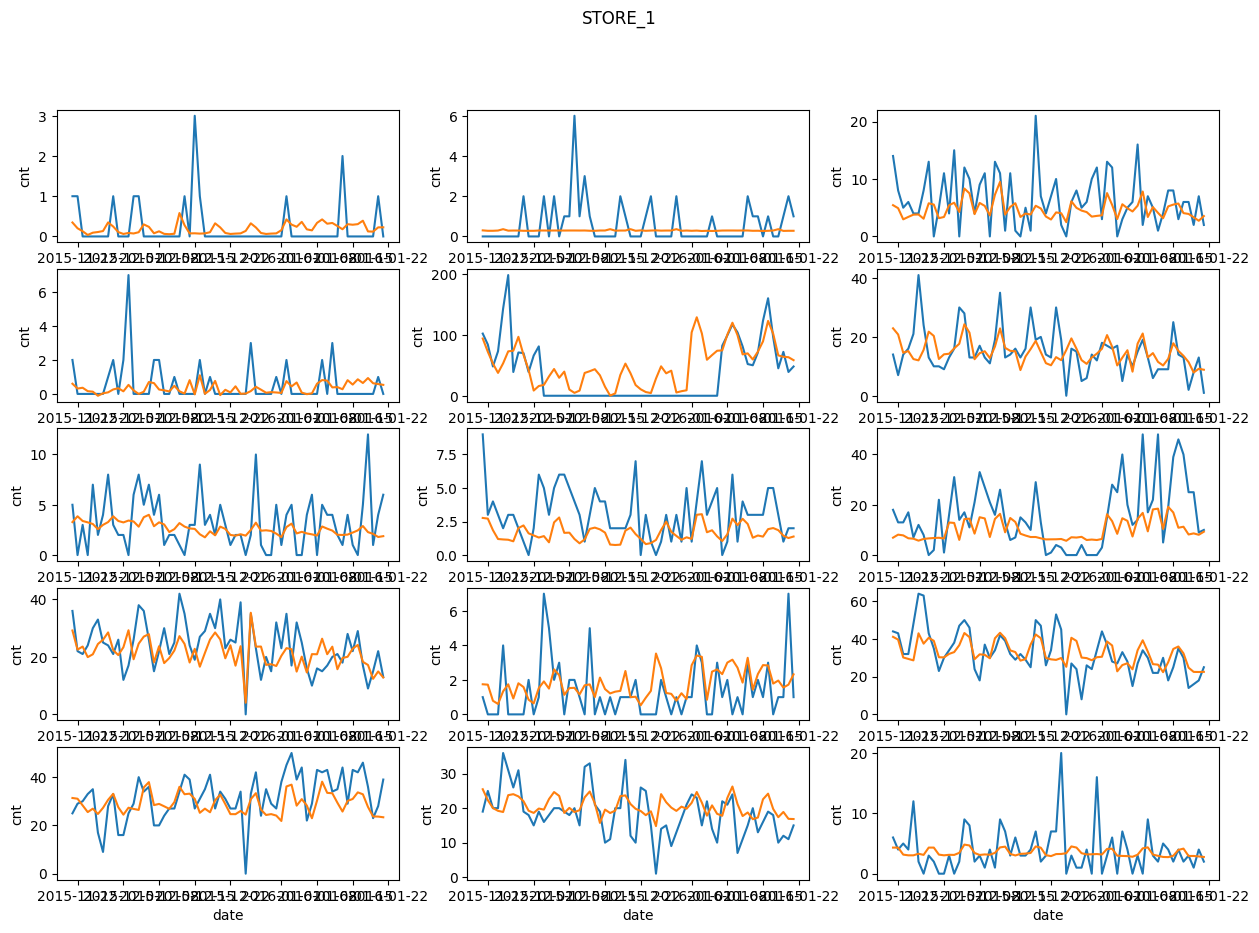

In [ ]:
fig,ax = plt.subplots(5,3,figsize=(15,10))

for i, art in enumerate(val_preds['item_id'].unique()):
    data = val_preds[val_preds['item_id']==art]
    data.set_index('date')
    sns.lineplot(data=data,
                 x='date',y='cnt',ax = ax[i//3][i%3])
    sns.lineplot(data=data,
                 x='date',y='cnt_pred',ax = ax[i//3][i%3])
plt.suptitle(STORE_ID)
plt.show()

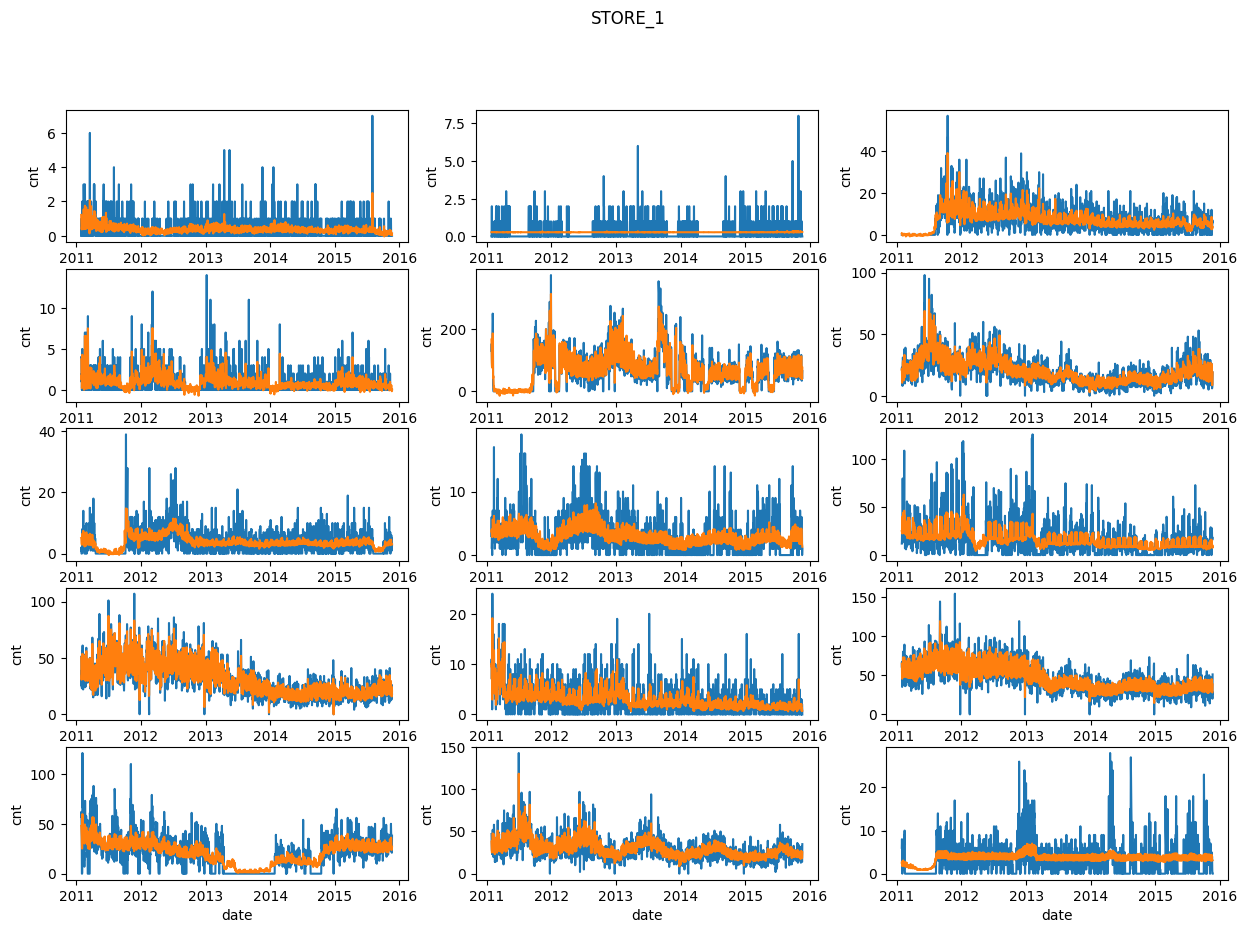

In [ ]:
fig,ax = plt.subplots(5,3,figsize=(15,10))

for i, art in enumerate(train_preds['item_id'].unique()):
    data = train_preds[train_preds['item_id']==art]
    data.set_index('date')
    sns.lineplot(data=data,
                 x='date',y='cnt',ax = ax[i//3][i%3])
    sns.lineplot(data=data,
                 x='date',y='cnt_pred',ax = ax[i//3][i%3])
plt.suptitle(STORE_ID)
plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression


train_data = train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)

def detrending(df, trend_model, target_col='cnt', seas_type='mult', dt_col='month'):
    df_trend = df.reset_index()
    X = df_trend.index.values
    y = df_trend[target_col].values
    trend_model.fit(X.reshape(-1, 1), y)
    y_pred = trend_model.predict(X.reshape(-1, 1))
    target_col_detrended = target_col + '_detrended'
    if seas_type not in ['add', 'mult']:
        raise ValueError('seas_type should be mult or add')
    elif seas_type == 'mult':
        df_trend[target_col_detrended] = df_trend[target_col] / y_pred
    else:
        df_trend[target_col_detrended] = df_trend[target_col] - y_pred
    df_trend = df_trend.set_index(dt_col)[[target_col_detrended]]
    df_trend['trend'] = y_pred
    return df_trend, trend_model, y_pred


def predict_trend(y_train, df_test, trend_model, target_col='cnt'):
    try:
        last_val = y_train.iloc[-1].values[0]
    except:
        last_val = y_train.iloc[-1]
    trend_predicts = []
    for _ in range(df_test.shape[0]):
        val = last_val + trend_model.coef_[0]
        last_val = val
        trend_predicts.append(val)
    df_test['trend'] = trend_predicts
    return df_test


def restore_trend(y_pred_detr, df_test, seas_type='mult', col='trend'):
    if seas_type not in ['add', 'mult']:
        raise ValueError('seas_type should be mult or add')
    elif seas_type == 'mult':
        y_pred = y_pred_detr * df_test[col].values
    else:
        y_pred = y_pred_detr + df_test[col].values
    return y_pred

In [ ]:
train_detrended, trend_lr, trend_ex = detrending(train_data, LinearRegression())

In [ ]:
y_test_trend = predict_trend(train_data['cnt'], val_data, trend_lr)

In [ ]:
models = {}
v_preds = []

for item in train_df['item_id'].unique():
    train_data = train_df[train_df['item_id']==item].reset_index(drop=True)
    val_data = val_df[val_df['item_id']==item].reset_index(drop=True)

    train_detrended, trend_lr, trend_ex = detrending(train_data, LinearRegression())
    y_test_trend = predict_trend(train_data['cnt'], val_data, trend_lr)

    train_pool = Pool(
        train_data[feature_names],
        train_data['cnt'],
        cat_features = cat_features,
        feature_names=feature_names
    )
    val_pool = Pool(
        val_data[feature_names],
        val_data['cnt'],
        cat_features = cat_features,
        feature_names=feature_names
    )

    cb_model = CatBoostRegressor(
                n_estimators=700,
                random_state=52,
                early_stopping_rounds=75,
                verbose=0,
                eval_metric='MAPE'
    )

    cb_model.fit(train_pool, eval_set=val_pool)
    models[item] = cb_model

    forecast = cb_model.predict(val_pool)
    y_pred = restore_trend(forecast, y_test_trend)
    val_data['cnt_pred'] = y_pred
    v_preds.append(val_data[['item_id', 'date', 'cnt', 'cnt_pred']])

val_preds = pd.concat(v_preds)

print(mean_absolute_error(val_preds['cnt'], val_preds['cnt_pred']))
print(mean_absolute_percentage_error(val_preds['cnt'], val_preds['cnt_pred']))
print('-' * 10)
print(mean_absolute_error(val_preds['cnt'][:7], val_preds['cnt_pred'][:7]))
print(mean_absolute_percentage_error(val_preds['cnt'][:7], val_preds['cnt_pred'][:7]))
print('-' * 10)
print(mean_absolute_error(val_preds['cnt'][:30], val_preds['cnt_pred'][:30]))
print(mean_absolute_percentage_error(val_preds['cnt'][:30], val_preds['cnt_pred'][:30]))

4.212720028583337
3101579364506423.0
----------
495.9278545187304
4.0665620478338406e+17
----------
0.28577409372101703
208943332658.3102
----------
0.33364644587436937
1117489018226.0627


In [ ]:
val_preds

,item_id,date,cnt,cnt_pred
0,STORE_1_064,2015-11-21,1,-0.000043
1,STORE_1_064,2015-11-22,1,-0.000051
2,STORE_1_064,2015-11-23,0,-0.000048
3,STORE_1_064,2015-11-24,0,-0.000019
4,STORE_1_064,2015-11-25,0,-0.000058
...,...,...,...,...
57,STORE_1_727,2016-01-17,2,0.141820
58,STORE_1_727,2016-01-18,3,0.101743
59,STORE_1_727,2016-01-19,1,0.103689
60,STORE_1_727,2016-01-20,4,0.102573


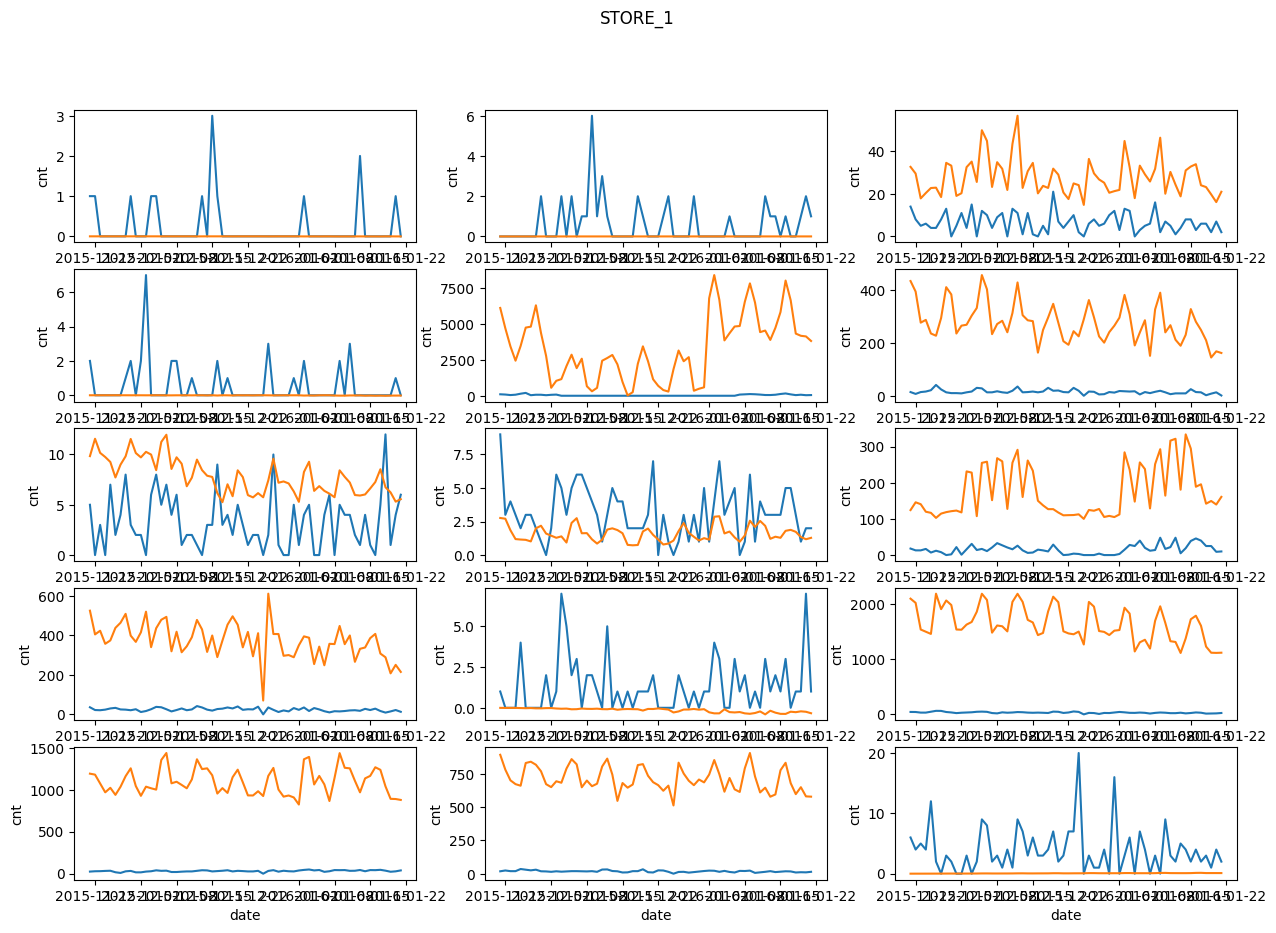

In [ ]:
fig,ax = plt.subplots(5,3,figsize=(15,10))

for i, art in enumerate(val_preds['item_id'].unique()):
    data = val_preds[val_preds['item_id']==art]
    data.set_index('date')
    sns.lineplot(data=data,
                 x='date',y='cnt',ax = ax[i//3][i%3])
    sns.lineplot(data=data,
                 x='date',y='cnt_pred',ax = ax[i//3][i%3])
plt.suptitle(STORE_ID)
plt.show()